# EDA: Exploración espacial de accidentes y vialidades en Hermosillo (2021–2023)

En esta *notebook* se realiza un **Análisis Exploratorio de Datos (EDA)** utilizando los conjuntos procesados que integran la base geoespacial del proyecto. El análisis se centra principalmente en dos fuentes:


* **Accidentes de Tránsito en Zonas Urbanas y Suburbanas (ATUS)** – fuente: INEGI.
* **Red de Vialidades Urbanas** – fuente: OpenStreetMap (OSM), obtenida mediante *OSMnx*.

Ambos conjuntos fueron previamente **limpiados, filtrados y estandarizados** para representar de manera consistente la **zona urbana de Hermosillo, Sonora**.

En el caso de OSM, se trabajó **sin aplicar un proceso de *dissolve*** a las vialidades, con el fin de conservar la mayor cantidad posible de información por segmento, especialmente en variables como **velocidad máxima** y **número de carriles**, que suelen variar dentro de una misma vialidad.

El propósito principal de esta libreta es **unificar y explorar** los datos de accidentes y vialidades para identificar patrones y relaciones espaciales.

La integración entre ambos conjuntos se realiza en la sección **2.0 Unificando los datos: Vialidades & ATUS**, utilizando `sjoin_nearest`. Esta operación permite **asignar a cada accidente el segmento de vialidad más cercano**, incorporando sus atributos geométricos y descriptivos.

A partir de esta unión, se desarrolla un EDA para examinar:

* La distribución espacial de los accidentes.
* Las características de las vialidades donde ocurren (tipo, longitud, velocidad máxima, carriles).
* Su posible relación con la frecuencia o severidad de los incidentes.

Esta exploración sirve como base para entender mejor el comportamiento espacial de los accidentes en Hermosillo y para preparar el terreno para análisis posteriores más específicos.


## 0. Configuración del entorno

In [1]:
import os 
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import folium as fl

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format) 

In [3]:
plt.style.use('seaborn-v0_8')

Definimos las rutas de acceso a los datos procesados ([*processed*](../data/processed/)): 

In [4]:
root = Path().resolve().parent
data_dir = root / "data"
processed_dir = data_dir / "processed"

for item in processed_dir.iterdir(): 
    print(item.relative_to(root))

data\processed\.gitkeep
data\processed\atus
data\processed\bachometro
data\processed\colonias
data\processed\eda
data\processed\vialidades


El contenido de cada directorio: 

In [5]:
for dirpath, _, files in os.walk(processed_dir): 
    print(f'Directory: {Path(dirpath).relative_to(root)}')
    for file_name in files: 
        print(file_name)

Directory: data\processed
.gitkeep
Directory: data\processed\atus
atus_clean.csv
atus_clean.geojson
Directory: data\processed\bachometro
baches_2021_limpio.csv
baches_2022_limpio.csv
baches_2023_limpio.csv
Directory: data\processed\colonias
colonias_hmo.geojson
colonias_hmo.gpkg
Directory: data\processed\eda
atus_eda.geojson
vialdiades_eda.geojson
vialidades_eda.geojson
vialidades_longitud.csv
Directory: data\processed\eda\unifications
atus-vialidad-baches.parquet
atus_vialidad.parquet
Directory: data\processed\vialidades
vialidades_hmo.geojson
vialidades_hmo.gpkg
vialidades_hmo_disolved.geojson
vialidades_hmo_disolved.gpkg


En esta libreta consideraremos el estudio de los datos: [ATUS-INEGI](../data/processed/atus/), y [Vialidades-OSM](../data/processed/vialidades/). 



Definimos las rutas para los datos: 

In [6]:
atus_path = processed_dir / "atus" / "atus_clean.geojson"
vialidades_path = processed_dir / "vialidades" / "vialidades_hmo.geojson"

In [7]:
for path in [atus_path, vialidades_path]: 
    print(path.relative_to(root), path.exists(), path.is_file(), sep=' - ')

data\processed\atus\atus_clean.geojson - True - True
data\processed\vialidades\vialidades_hmo.geojson - True - True


Definimos algunas rutas a directorios auxiliares: 

In [ ]:
eda_dir = processed_dir / "eda"
eda_dir.mkdir(exist_ok=True)

In [9]:
unifications_path = eda_dir / "unifications"
unifications_path.mkdir(exist_ok=True)

In [10]:
plots_dir = root / "plots"
plots_dir.mkdir(exist_ok=True)

### 0.1 Algunas funciones auxiliares

In [12]:
def add_basemap_to_ax(ax, crs):
    ctx.add_basemap(
        ax, 
        source=ctx.providers.OpenStreetMap.Mapnik, 
        crs=crs.to_string()
    )

In [13]:
def basic_popup(row, cols):
    lines = [f"<b>{col}</b>: {row[col]}" for col in cols]
    return "<br>".join(lines)

In [14]:
def get_nonzero_vehicles(gdf): 
    vehicles = [
        'automovil',
        'campasaj',
        'microbus',
        'pascamion',
        'omnibus',
        'tranvia',
        'camioneta',
        'camion',
        'tractor',
        'ferrocarri',
        'motociclet',
        'bicicleta',
        'otrovehic',
    ]
    gdf_vehicles = gdf[vehicles]
    gdf_sum = gdf_vehicles.sum(axis=0).reset_index(name='count')
    gdf_sum.columns = ['vehicle', 'count']
    nonzero_cols = gdf_sum[gdf_sum['count'] > 0].vehicle
    return nonzero_cols

In [15]:
def get_hermosillo_map():
    hermosillo_coords = (29.072967, -110.955919)
    return fl.Map(location=hermosillo_coords, zoom_start=12)

## 1. Carga, descripción general y validación de los datos


Definimos los *GeoDataFrames* de cada conjunto de datos: 

In [ ]:
atus = gpd.read_file(atus_path)
vialidades = gpd.read_file(vialidades_path)

### 1.1 ATUS

Los primeros registros: 

In [ ]:
atus.head(3)

Información general: 

In [ ]:
atus.info();

Los valores nulos por colunna: 

In [ ]:
atus.isnull().mean(); 

La columna 'carretera' posee el 99% de valores nulos, podemos eliminarla: 

In [ ]:
atus.drop(columns=['carretera'], inplace=True)

Las columnas 'calle1', 'calle2' podemos eliminarlas, ya que podemos obtenerlas a partir del conjunto de datos vialdiades-OSM: 

In [ ]:
atus.drop(columns=['calle1', 'calle2'], inplace=True)

La columna 'oid' es el número de identificación generado en QGIS. Podemos eliminarla:  

In [ ]:
atus.drop(columns=['oid'], inplace=True)

El total de registros, columnas: 

In [ ]:
atus.shape

Reorganizamos las columnas: 

In [ ]:
columns_atus = [
    'id', 'datetime', 'anio', 'mes', 'dia', 'hora', 'minutos', 'diasemana',
    'urbana', 'suburbana', 'longitud', 'latitud', 'geometry',
    'tipaccid', 'causaacci', 'caparod', 'clase',
    'automovil', 'campasaj', 'microbus', 'pascamion', 'omnibus', 'tranvia',
    'camioneta', 'camion', 'tractor', 'ferrocarri', 'motociclet',
    'bicicleta', 'otrovehic',
    'sexo', 'edad', 'aliento', 'cinturon',
    'condmuerto', 'condherido', 'pasamuerto', 'pasaherido',
    'peatmuerto', 'peatherido', 'ciclmuerto', 'ciclherido',
    'otromuerto', 'otroherido', 'totmuertos', 'totheridos'
]

atus = atus[columns_atus]

Guardamos el conjunto para futuras exploraciones: 

In [ ]:
atus.to_file(eda_dir.joinpath('atus_eda.geojson'), driver='GeoJSON')

### 1.2 Vialidades

Los primeros registros: 

In [ ]:
vialidades.head(3)

Información general: 

In [ ]:
vialidades.info()

Renombramos la columna `longitud` a `longitud_osm`: 

In [ ]:
vialidades.rename(columns={'longitud': 'longitud_m'}, inplace=True)

Los valores nulos por colunna: 

In [ ]:
vialidades.isnull().mean()

Las columnas `vel_max` y `num_carriles` poseen alrrededor del 95% de datos nulos. 

El total de registros, columnas: 

In [ ]:
vialidades.shape

Las columnas: 

In [ ]:
columns_vialidades = vialidades.columns.tolist()
columns_vialidades; 

#### 1.2.1 Columna `vel_max`

La variable de velocidad máxima, `vel_max`, es un factor importante para caracterizar una vialidad. 

Dicha columna posee los siguientes valores únicos:

In [ ]:
vialidades['vel_max'].unique()

In [ ]:
vialidades['vel_max'].value_counts()

Por tipo cada tipo de vialidad, contamos la cantidad de veces que aparece cada velocidad máxima única: 

In [ ]:
pd.crosstab(vialidades['tipo_vialidad'], vialidades['vel_max'])

En la tabla anterior, observamos que **vialidades del mismo tipo tienden a tener rangos de velocidades similares**. 

Exploremos las vialidades que poseen valores en la columna `vel_max`:

In [ ]:
vialidades[~vialidades['vel_max'].isnull()]\
    .explore()\
        .save(plots_dir.joinpath('temp.html'))

In [ ]:
vialidades[vialidades['vel_max'] == '110']; 

Observamos que la velocidad máxima es reprecentada como una `str`. 

En tramos donde la velocidad varia, las posibles velocidades que posee la vialidad son separadas por `,`. 

Este tipo de reprecentación de las velocidades no permite trabajar estadísticas importantes, como velocidad promedio por tipo de vialidad, entre otras. 

Definimos la función para transformar la velocidad máxima a `float`: 

In [ ]:
def vel_max_to_float(vel_str):
    if vel_str is None:
        return None

    try:
        if ';' in vel_str:
            vels = [float(v) for v in vel_str.split(';') if v.strip()]
            if not vels:
                return None
            avg = sum(vels) / len(vels)
        else:
            avg = float(vel_str)
        
        return round(avg, -1)
    
    except ValueError:
        return None

In [ ]:
vialidades['vel_max_float'] = vialidades['vel_max'].apply(vel_max_to_float)

In [ ]:
vialidades['vel_max_float'].describe()

Agrupamos por tipo de vialidad y calculamos la media de la velocidad máxima promedio: 

In [ ]:
vialidades.groupby(['tipo_vialidad'])['vel_max_float'].mean()

Podemos imputar los valores faltantes en `vel_max_kmh`. 

Para ello utilizaremos el promedio por tipo de vialidad, asumiendo que el límite de velocidad depende principalmente de la jearquía de la vía establecido por OSM. 

Definimos el diccionario de velocidades por tipo de vialidad:

In [ ]:
tabla_vel = {
    'autopista': 110,
    'carretera principal': 90,
    'conector carretera': 70,
    'conector autopista': 60,
    'vía primaria': 60,
    'vía secundaria': 60,
    'vía terciaria': 60,
    'conector primaria': 60,
    'conector secundaria': 30,
    'conector terciaria': 30,  
    'calle residencial': 30,
    'calle menor': 30,
    'calle peatonal': None,
}

Definimos la columna `vel_max_est` que posee información sobre la velocidad máxima estimada en función del tipo de vialidad y las métricas anteriores: 

In [ ]:
vialidades['vel_max_est'] = vialidades['tipo_vialidad'].map(tabla_vel)

In [ ]:
vialidades['vel_max_est'].describe()

Eliminamos las columnas auxiliares: 

In [ ]:
vialidades.drop(columns='vel_max_float', inplace=True)

#### 1.2.2 Columna `num_carriles`

Los valores únicos en la columna: 

In [ ]:
vialidades['num_carriles'].unique()

In [ ]:
vialidades['num_carriles'].value_counts()

Por tipo cada tipo de vialidad, contamos la cantidad de veces que aparece cada número de carriles: 

In [ ]:
pd.crosstab(vialidades['tipo_vialidad'], vialidades['num_carriles'])

Al igual que la velocidad máxima, la cantidad de carriles de una vialdiad es una propiedad importante. Por lo tanto, es convinente imputar datos nulos. 

La cantidad de carriles es de tipo *discreta*, la estrategía de imputación adecuada es la *moda*, es decir, los valores nulos serán el número de carriles más frecuente por tipo de vialidad. 

Extraemos el  número de carriles base: 

In [ ]:
vialidades['num_carriles_float'] = (
    vialidades['num_carriles']
    .str.extract('(\d+)')
    .astype(float)
)

Calculamos la moda por tipo de vialidad: 

In [ ]:
moda_carriles = (
    vialidades
    .dropna(subset=['num_carriles_float'])
    .groupby('tipo_vialidad')['num_carriles_float']
    .agg(lambda x: x.mode().iloc[0])
)
moda_carriles


Definimos la columna `num_carriles_est` reprecenta la cantidad de carriles estimada en función del tipo de vialidad y la moda por cada número de carriles: 

In [ ]:
vialidades['num_carriles_est'] = (
    vialidades['num_carriles_float']
    .fillna(vialidades['tipo_vialidad'].map(moda_carriles))
)

In [ ]:
vialidades['num_carriles_est'].describe()

In [ ]:
vialidades[vialidades['num_carriles_est'] == 5].explore(); 

Eliminamos las columnas auxiliares: 

In [ ]:
vialidades.drop(columns=['num_carriles_float'], inplace=True)

Eliminamos columnas relacionadas a `osmnx` para la construcción de Grafos: 

In [ ]:
cols_to_drop = [
    'u','v','key','osmid', 'reversed',
    'vel_max','num_carriles',
]

vialidades.drop(columns=cols_to_drop, inplace=True)


Reordenamos columnas:

In [ ]:
vialidades_cols = [
    "tipo_vialidad",
    "nombre_vialidad",
    "un_sentido",
    "longitud_m",
    "vel_max_est",
    "num_carriles_est",
    "geometry"
]
vialidades = vialidades[vialidades_cols]

In [ ]:
vialidades.head()

Guardamos los datos para futuros análisis: 

In [ ]:
vialidades.to_file(eda_dir.joinpath("vialdiades_eda.geojson"), driver='GeoJSON')

## 2. Unifocando los datos: Vialidades & ATUS

In [ ]:
atus = gpd.read_file(eda_dir.joinpath("atus_eda.geojson"))
vialidades = gpd.read_file(eda_dir.joinpath("vialidades_eda.geojson"))

In [ ]:
atus_vialidad_path = unifications_path.joinpath("atus_vialidad.parquet")

Anteriormente se verificó que los datos poseen la misma *crs*, por lo que no será necesario proyectar en otro sistema de referencia.

Además, los tipos de geometrías en cada conjunto de datos son: 
* Atus: Cada accidente se reprecenta como un objeto tipo `Point`
* Vialidades: Cada vialidad se reprecenta por un objeto `LineString`

Para relacionar los datos realizaremos un `spatial join`, donde a cada accidente se le asignará la gometría más cercana o la que interseca a el punto.

Usamremos el método `GeoPandas.sjoin_nearest`. 

Relacionamos las vialidades con el conjunto atus: 

In [ ]:
vialidades = vialidades.rename_geometry('geometry_vialidad')

In [ ]:
vialidades.head()

In [ ]:
atus_vialidad = gpd.sjoin_nearest(
    atus,
    vialidades, 
    how='left', 
    distance_col='distance_m'
)

Mapeamos las geometrías de los tramos de vialidad al respectivo accidente: 

In [ ]:
atus_vialidad['geometry_vialidad'] = atus_vialidad['index_right'].map(
    vialidades.geometry
)


In [ ]:
atus_vialidad.head(3)


Guardamos los resultados: 

In [ ]:
atus_vialidad.to_parquet(atus_vialidad_path)

## 3. Explorando las vialidades y accidentes de tránsito

In [16]:
atus = gpd.read_file(eda_dir.joinpath("atus_eda.geojson"))
vialidades = gpd.read_file(eda_dir.joinpath("vialidades_eda.geojson"))
atus_vialidad = gpd.read_parquet(unifications_path.joinpath("atus_vialidad.parquet"))

In [17]:
atus_vialidad.head(3)

,id,datetime,anio,mes,dia,hora,minutos,diasemana,urbana,suburbana,...,nombre_vialidad,un_sentido,longitud_m,vel_max,num_carriles,vel_max_kmh,vel_max_est,num_carriles_est,distance_m,geometry_vialidad
0,1006278-999-1,2021-01-01 14:55:00,2021,1,1,14,55,viernes,intersección,urbana,...,arizona,False,53.37,None,None,NaN,30.00,2.00,0.00,"LINESTRING (-110.97742 29.11936, -110.97735 29..."
0,1006278-999-1,2021-01-01 14:55:00,2021,1,1,14,55,viernes,intersección,urbana,...,arizona,False,53.37,None,None,NaN,30.00,2.00,0.00,"LINESTRING (-110.97735 29.11888, -110.97742 29..."
1,1006278-999-2,2021-01-01 15:20:00,2021,1,1,15,20,viernes,intersección,urbana,...,boulevard solidaridad,True,82.11,60,5,60.00,65.00,5.00,0.00,"LINESTRING (-110.99475 29.13643, -110.99449 29..."


### 3.1 Descripción básica

El **total de accidentes georreferenciados registrados entre 2021-2023**: 

In [19]:
tot_acc = len(atus_vialidad)
tot_acc

36716

El total de registros en el conjunto Vialidades-OSM: 

In [20]:
len(vialidades)

154813

EL total de **segmentos de vialidades sin nombre**: 

In [21]:
mask_noname = vialidades['nombre_vialidad'] == 'SIN_NOMBRE'

In [22]:
mask_noname.value_counts()

nombre_vialidad
False    88635
True     66178
Name: count, dtype: int64

El total de **segmentos con nombre**: 

In [23]:
len(vialidades[~mask_noname])

88635

El total de vialidades con nombre único: 

In [24]:
len(vialidades['nombre_vialidad'].unique())

4727

---

¿Cuáles son las vialidades con mayor cantidad de accidentes?

Agrupamos por nombre de vialidad y tipo de vialidad: 

In [25]:
acc_por_vialdiad = (
    atus_vialidad.groupby(['nombre_vialidad', 'tipo_vialidad'])
    .size()
    .reset_index(name='num_accidentes')
)
acc_por_vialdiad

,nombre_vialidad,tipo_vialidad,num_accidentes
0,1 de mayo,calle residencial,8
1,12 de octubre,calle residencial,180
2,14 de abril,calle residencial,59
3,14 de abril,vía terciaria,9
4,16 de septiembre,calle residencial,5
...,...,...,...
1694,zacatecas,calle residencial,34
1695,zapateros,calle residencial,2
1696,zoila reyna de palafox,calle residencial,5
1697,álvaro nu~ez,calle residencial,2


El porcentage sobre el total de accidentes: 

In [26]:
acc_por_vialdiad['prop_accidentes'] = 100*acc_por_vialdiad['num_accidentes']/tot_acc

La longitud en metros de cada vialdidad: 

In [27]:
vialidades[vialidades['nombre_vialidad'] == 'boulevard josé maría morelos norte']['longitud_m'].sum()

np.float64(11807.290962813491)

In [28]:
vialidad_long_tot = (
    vialidades.groupby('nombre_vialidad')['longitud_m']
    .sum()
)

In [29]:
acc_por_vialdiad['longitud_total_m'] = acc_por_vialdiad['nombre_vialidad'].map(vialidad_long_tot)

Obtengamos ahora la cantidad de accidentes cada kilómetro: 

In [31]:
acc_por_vialdiad['acc_por_km'] = np.ceil(1000*acc_por_vialdiad['num_accidentes']/acc_por_vialdiad['longitud_total_m']).astype(int)

In [ ]:
acc_por_vialdiad.to_csv(eda_dir / "acc_vialidad.csv")a

Las top 10 vialidades con más accidentes: 

In [32]:
top_10 = (
    acc_por_vialdiad
    .nlargest(10, 'num_accidentes',)
    .sort_values(by=['num_accidentes', 'acc_por_km'], ascending=[False, False])
)
top_10

,nombre_vialidad,tipo_vialidad,num_accidentes,prop_accidentes,longitud_total_m,acc_por_km
557,boulevard solidaridad,vía primaria,2996,8.16,40652.73,74
10,SIN_NOMBRE,calle residencial,1365,3.72,2535112.78,1
505,boulevard josé maría morelos norte,vía primaria,819,2.23,11807.29,70
545,boulevard progreso,vía primaria,724,1.97,13991.83,52
456,boulevard antonio quiroga,vía primaria,706,1.92,8612.77,82
503,boulevard jesús garcía morales,vía primaria,669,1.82,11812.70,57
1262,luis encinas johnson,vía primaria,664,1.81,8722.45,77
1089,francisco monteverde,vía secundaria,404,1.10,10550.38,39
644,calle de la reforma,vía secundaria,391,1.06,6783.95,58
22,abelardo l rodriguez,vía primaria,384,1.05,3212.77,120


In [33]:
top_10.to_markdown("../reports/top_10_vialidades_accidentes.md")

* El 'Boulevard Solidaridad' posee el 8% de los accidentes ocurridos en el periodo 2021-2023. Le siguen el 'Boulevard José María Morelos Norte' con el 3.7% y el Boulevard Progreso con casí el 2%. 


* Las calles residenciales sin nombre poseen casí el 4% de accidentes ocurridos. 

* La calle con mayor cantidad de accidentes por kilómetro es 'Abelardo L Rodríguez' con 120 accidentes/km. 

In [34]:
top_10_vialidades = top_10['nombre_vialidad'].tolist()
top_10_vialidades

['boulevard solidaridad',
 'SIN_NOMBRE',
 'boulevard josé maría morelos norte',
 'boulevard progreso',
 'boulevard antonio quiroga',
 'boulevard jesús garcía morales',
 'luis encinas johnson',
 'francisco monteverde',
 'calle de la reforma',
 'abelardo l rodriguez']

---
¿Cómo se distribuyen los accidentes por tipo de vialidad?

In [35]:
acc_tipo_vialidad = atus_vialidad['tipo_vialidad'].value_counts().reset_index(name='tot_acc')
acc_tipo_vialidad

,tipo_vialidad,tot_acc
0,calle residencial,13528
1,vía primaria,11010
2,vía terciaria,6324
3,vía secundaria,4277
4,carretera principal,660
5,calle menor,394
6,conector primaria,346
7,conector carretera,129
8,conector secundaria,32
9,conector terciaria,7


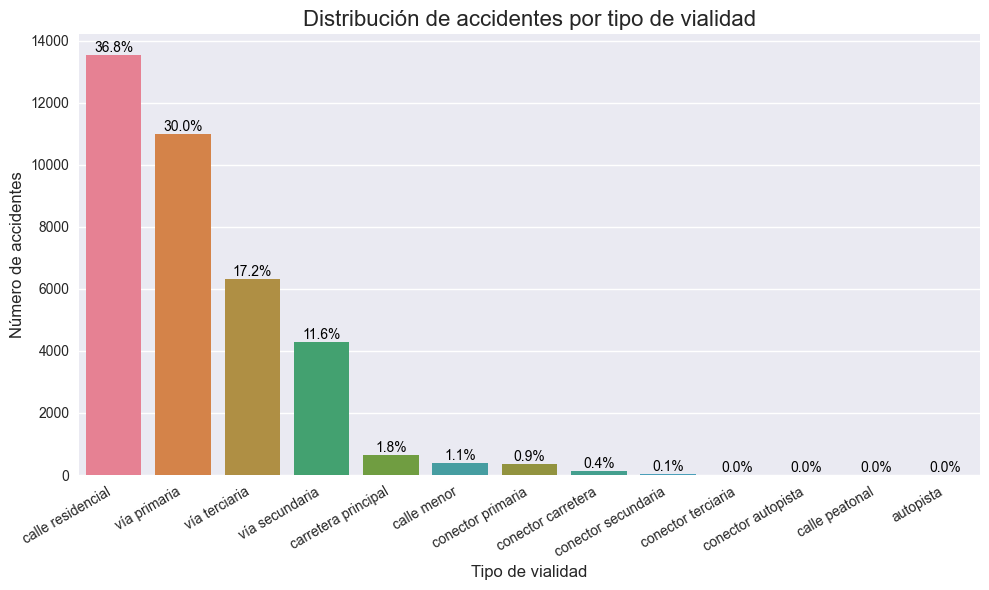

In [36]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(
    data=atus_vialidad,
    x="tipo_vialidad",
    order=atus_vialidad["tipo_vialidad"].value_counts().index,  # ordenado
    hue='tipo_vialidad', 
)

ax.set_title("Distribución de accidentes por tipo de vialidad", fontsize=16)
ax.set_xlabel("Tipo de vialidad", fontsize=12)
ax.set_ylabel("Número de accidentes", fontsize=12)
plt.xticks(rotation=30, ha="right")

for p in ax.patches:
    height = p.get_height()
    pct = 100 * height / tot_acc  # porcentaje
    ax.annotate(
        f"{pct:.1f}%",
        (p.get_x() + p.get_width() / 2, height),
        ha="center", va="bottom",
        fontsize=10, color="black", rotation=0
    )


plt.tight_layout()
plt.savefig("../plots/accidentes_tipo_vialidad.png")
plt.show()

---
¿Cuántas vialidades tiene almenos un accidente?

In [43]:
len(atus_vialidad['nombre_vialidad'].unique()) / 4727

0.3386926168817432

La distribución del número de accidentes por vialidad: 

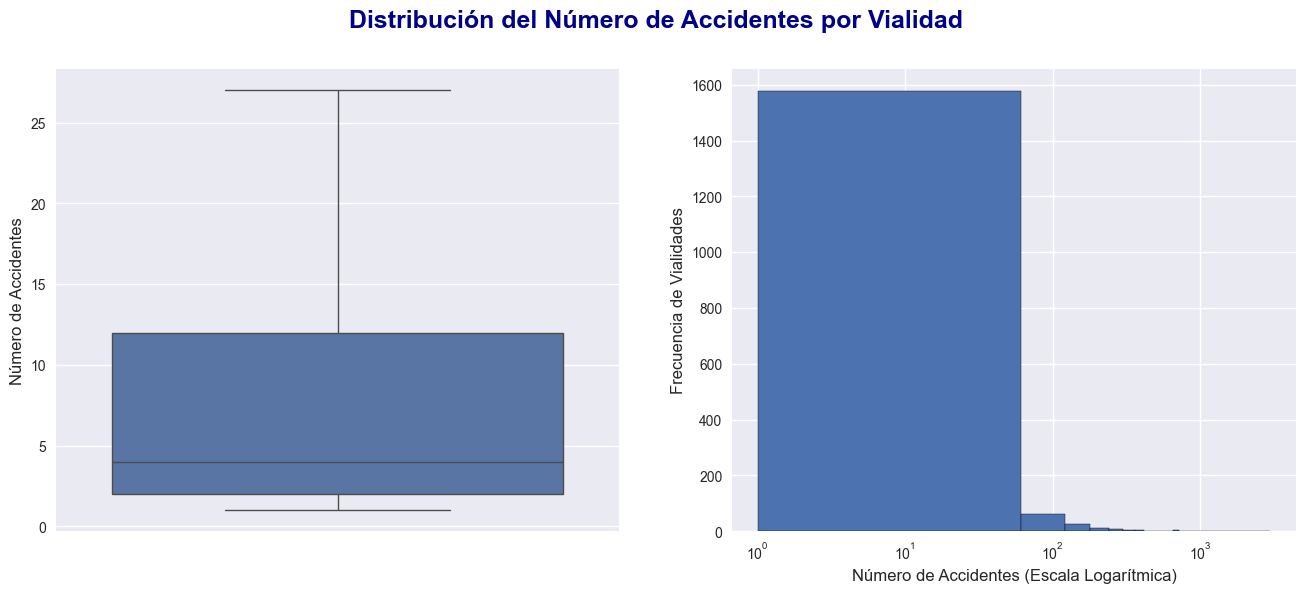

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# boxplot
sns.boxplot(
    data=acc_por_vialdiad, 
    y='num_accidentes',
    showfliers=False, # no-outliers
    ax=axs[0]
)

axs[0].set_ylabel('Número de Accidentes', fontsize=12)

# histogram
acc_por_vialdiad['num_accidentes'].hist(bins=50, ax=axs[1], edgecolor='black')
axs[1].set_xscale("log", base=10)  # Escala logarítmica en el eje X
axs[1].set_xlabel("Número de Accidentes (Escala Logarítmica)", fontsize=12)
axs[1].set_ylabel("Frecuencia de Vialidades", fontsize=12)

fig.suptitle('Distribución del Número de Accidentes por Vialidad', fontsize=18, fontweight='bold', color='darkblue')
plt.savefig("../plots/distribucion_num_acc.png")
plt.show()

In [44]:
np.quantile(
    acc_por_vialdiad['num_accidentes'], 
    [0.0, 0.25, 0.5, 0.75, 1.0]
)

array([1.000e+00, 2.000e+00, 4.000e+00, 1.200e+01, 2.996e+03])

Sin considerar outliers: 

* El 25% de las vialidades tienen menos de 2 accidentes. 

* EL 50% de las vialidades tienen menos de 4 accidentes. 

* El 75% de las vialdidades tienen menos de 12 accidentes. 

* El número máximo de accidentes es 2996. 

* Casí 1600 vialidades, de las 1700 poseen entre 1 y 10 accidentes vialdes. Las 100 vialidades restantes poseén más de 100 accidentes. 

---


### 3.2 Exploración espacial: ¿Dónde y cómo ocurren?

---
¿los accidentes se concentraen en vialidades de mayor longitud o mayor número de carroles?

Consideremos un *scatterplot* de la cantidad de accidentes y la longitud de la vialidad: 

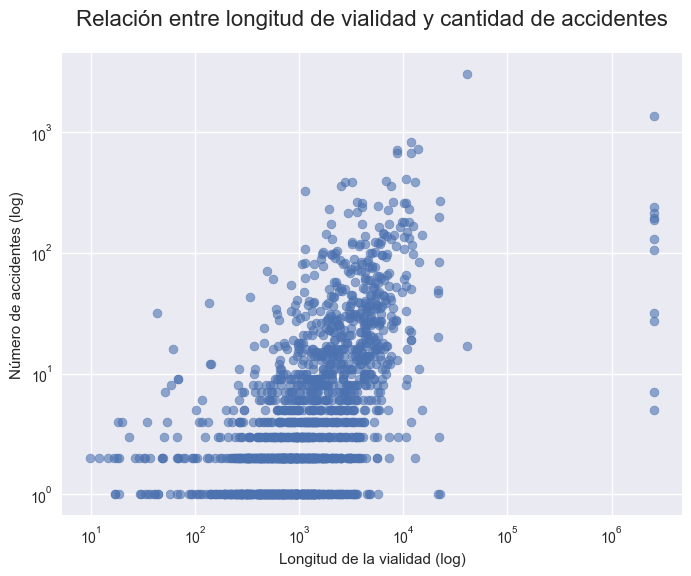

In [48]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=acc_por_vialdiad,
    x='longitud_total_m',
    y='num_accidentes',
    alpha=0.6,
    s=40,
    edgecolor=None
)
plt.xscale('log')
plt.yscale('log')
plt.title('Relación entre longitud de vialidad y cantidad de accidentes', fontsize=16, pad=20)
plt.xlabel('Longitud de la vialidad (log)')
plt.ylabel('Número de accidentes (log)')
plt.savefig("../plots/corr_long_numaccid.png")
plt.show()

* En la figuta anterior observamos una relación positiva entre el número de accidentes y la longitud de la vialdiad. 

* La correlación entre el número de accidentes y la longitud total: 

In [49]:
np.corrcoef(acc_por_vialdiad['num_accidentes'], acc_por_vialdiad['longitud_total_m'])

array([[1.        , 0.17754989],
       [0.17754989, 1.        ]])

Ahora, el total de accidentes por cantidad de carriles: 

In [50]:
atus_vialidad['num_carriles_est'] = atus_vialidad['num_carriles_est'].fillna(0)

In [51]:
atus_vialidad['num_carriles_est'] = atus_vialidad['num_carriles_est'].apply(int).apply(str)

In [52]:
acc_num_carr = atus_vialidad['num_carriles_est'].value_counts().reset_index(name='total_acc')

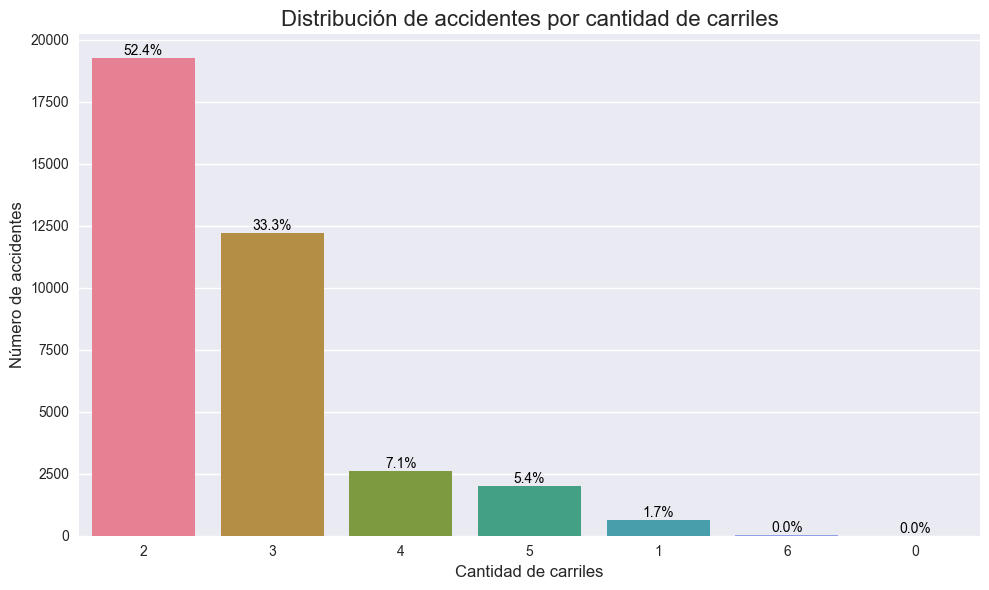

In [53]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(acc_num_carr, x='num_carriles_est', y='total_acc', hue='num_carriles_est')

ax.set_title("Distribución de accidentes por cantidad de carriles", fontsize=16)
ax.set_xlabel("Cantidad de carriles", fontsize=12)
ax.set_ylabel("Número de accidentes", fontsize=12)

for p in ax.patches:
    height = p.get_height()
    pct = 100 * height / tot_acc  # porcentaje
    ax.annotate(
        f"{pct:.1f}%",
        (p.get_x() + p.get_width() / 2, height),
        ha="center", va="bottom",
        fontsize=10, color="black", rotation=0
    )


plt.tight_layout()
plt.savefig("../plots/accidentes_num_carriles.png")
plt.show()

* Más del 50% de los accidentes se concentran en vialidades con 2 carriles, le siguen vialidades con 3 carriles con un 33%. 

Consideremos la cantidad de carriles real: 

In [54]:
atus_vialidad['num_carriles'].unique()

array([None, '5', '2', '4', '3', '2;3', '1', '6'], dtype=object)

In [106]:
tot_acc_numcarr = atus_vialidad['num_carriles'].notnull().sum()
tot_acc_numcarr

np.int64(8770)

In [108]:
atus_vialidad['num_carriles'].notnull().value_counts(normalize=True)

num_carriles
False   0.76
True    0.24
Name: proportion, dtype: float64

* De los +36000 accidentes, aproximadamente el 24% posee vialidad con información sobre el númerode carriles: 

In [61]:
len(atus_vialidad[atus_vialidad['num_carriles'].notnull()]['nombre_vialidad'].unique())

83

In [66]:
accidentes_carriles = atus_vialidad['num_carriles'].value_counts().reset_index(name='total_acc')

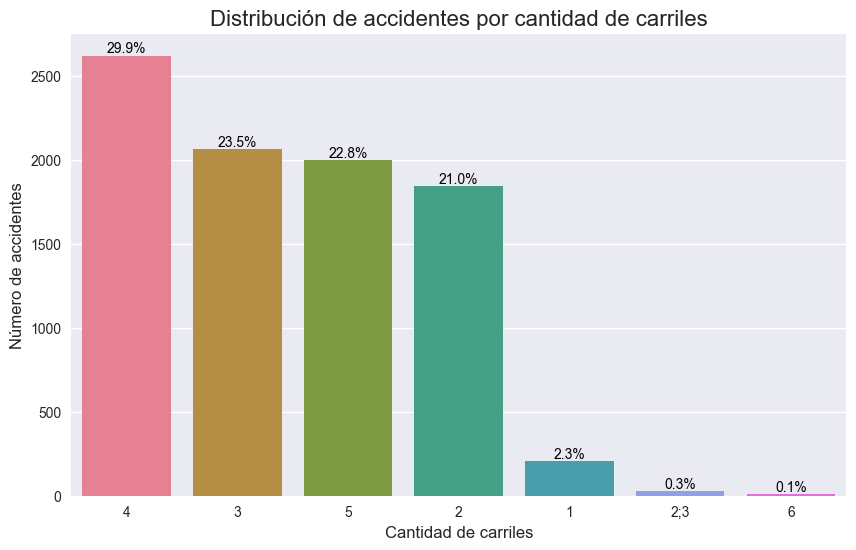

In [109]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(accidentes_carriles, x='num_carriles', y='total_acc', hue='num_carriles')

ax.set_title("Distribución de accidentes por cantidad de carriles", fontsize=16)
ax.set_xlabel("Cantidad de carriles", fontsize=12)
ax.set_ylabel("Número de accidentes", fontsize=12)

for p in ax.patches:
    height = p.get_height()
    pct = 100 * height / tot_acc_numcarr  # porcentaje
    ax.annotate(
        f"{pct:.1f}%",
        (p.get_x() + p.get_width() / 2, height),
        ha="center", va="bottom",
        fontsize=10, color="black", rotation=0
    )


plt.savefig("../plots/accidentes_num_carriles.png")
plt.show()

---
¿Existe relación entre la velocidad máxima y el número ó gravedad de accidentes?

In [70]:
atus_vialidad['vel_max_est'].describe()

count   36713.00
mean       48.09
std        16.21
min        30.00
25%        30.00
50%        45.00
75%        65.00
max       110.00
Name: vel_max_est, dtype: float64

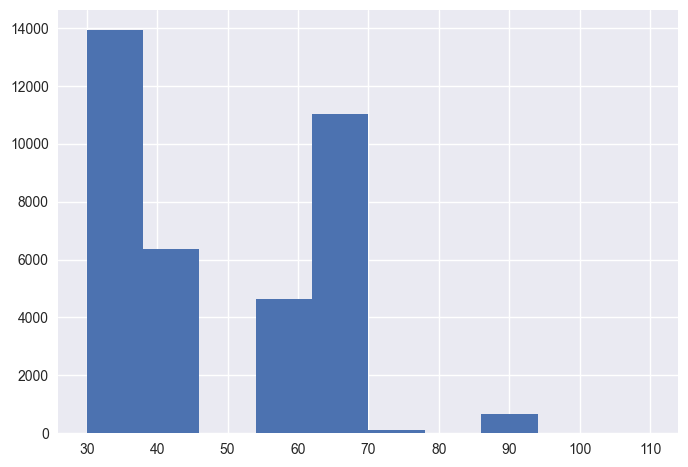

In [76]:
atus_vialidad['vel_max_est'].hist()
plt.show()

In [77]:
atus_vialidad['clase'].unique()

array(['solo daños', 'no fatal', 'fatal'], dtype=object)

El total de accidentes cuya vialidad asociada posee información sobre la velocidad máxima: 

In [92]:
tot_acc_velmax = atus_vialidad['vel_max'].notnull().sum()
tot_acc_velmax

np.int64(6989)

In [88]:
atus_vialidad['vel_max'].isnull().value_counts()

vel_max
True     29727
False     6989
Name: count, dtype: int64

* Aproximadamente el 20% de los accidentes posee asociado un segemento de vialidad con información sobre la velocidad máxima. 

Agrupamos por clase de accidente y velocidad máxima: 

In [80]:
clase_velmax = atus_vialidad.groupby(['clase', 'vel_max']).size().unstack(fill_value=0)

In [81]:
df_clase_velmax = (
    clase_velmax
    .reset_index()
    .melt(id_vars='clase', var_name='vel_max', value_name='count')
)
df_clase_velmax; 

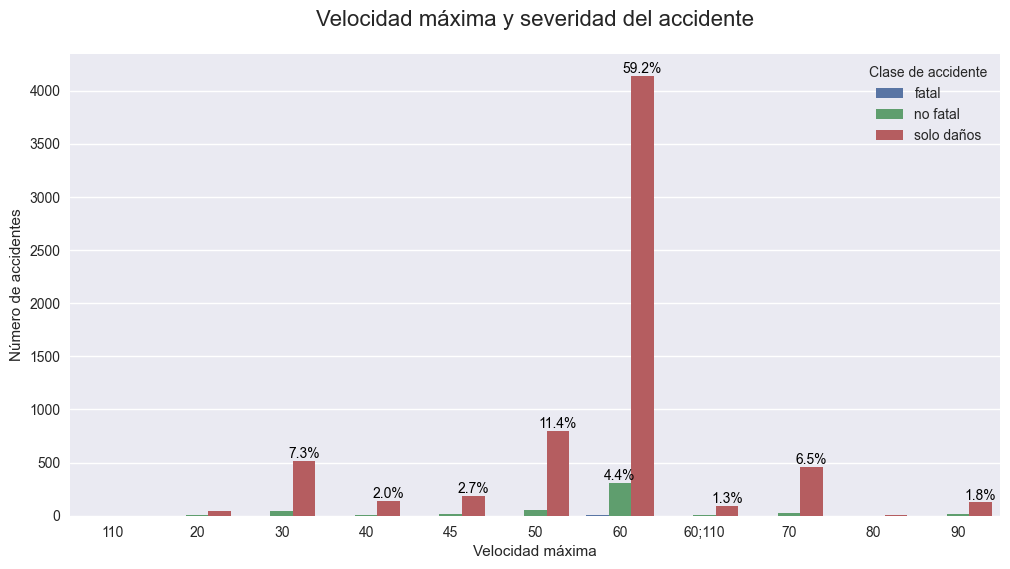

In [105]:
plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=df_clase_velmax,
    x="vel_max",
    y="count",
    hue="clase",
)

plt.title("Velocidad máxima y severidad del accidente", fontsize=16, pad=20)
plt.xlabel("Velocidad máxima")
plt.ylabel("Número de accidentes")

for p in ax.patches:
    height = p.get_height()
    pct = height / tot_acc_velmax  # porcentaje
    if pct > 0.01: 
        pct = 100*pct
        ax.annotate(
        f"{pct:.1f}%",
        (p.get_x() + p.get_width() / 2, height),
        ha="center", va="bottom",
        fontsize=10, color="black", rotation=0
    )

plt.legend(title="Clase de accidente", frameon=False)
plt.savefig("../plots/velmax_clase_acc.png")
plt.show()

Intentemos contestar la pregunta: 

Los accidentes fatales con datos de velocidad máxima: 

In [112]:
atus_vialidad_maxvel = atus_vialidad[atus_vialidad['vel_max'].notnull()]

In [ ]:
assert len(atus_vialidad_maxvel) == tot_acc_velmax

In [121]:
accidentes_maxvel = pd.crosstab(atus_vialidad_maxvel['clase'], atus_vialidad_maxvel['vel_max'])
accidentes_maxvel['total_clase'] = accidentes_maxvel.sum(axis=1)
accidentes_maxvel

vel_max,110,20,30,40,45,50,60,60;110,70,80,90,total_clase
clase,,,,,,,,,,,,
fatal,0,0,0,1,0,0,9,1,1,0,2,14
no fatal,0,4,41,10,12,54,309,6,26,0,12,474
solo daños,2,46,512,139,189,797,4140,89,456,6,125,6501


* Contamos con **solo 14 accidentes fatales con datos de velocidad máxima, la muestra es demasiado pequeña para jacer inferencias sólidas sobre la relación entre velocidad límite y fatalidad**. 

---
¿Que tipo de vialidades concentran los accidentes fatales? 

In [159]:
pd.crosstab(atus_vialidad['tipo_vialidad'], atus_vialidad['clase'])

clase,fatal,no fatal,solo daños
tipo_vialidad,,,
autopista,0,0,1
calle menor,3,29,362
calle peatonal,0,0,3
calle residencial,26,1018,12484
carretera principal,1,51,608
conector autopista,0,1,4
conector carretera,0,8,121
conector primaria,1,24,321
conector secundaria,0,7,25


Agrupemos por tipo de vialidad y fatalidad de accidente: 

In [136]:
clase_tipo_vialidad = (
    atus_vialidad
    .groupby(['tipo_vialidad', 'clase'])
    .size()
    .unstack(fill_value=0)
)
clase_tipo_vialidad; 

In [139]:
df_clase_tipov = (
    clase_tipo_vialidad
    .reset_index()
    .melt(id_vars='tipo_vialidad', var_name='clase', value_name='total_acc')
)

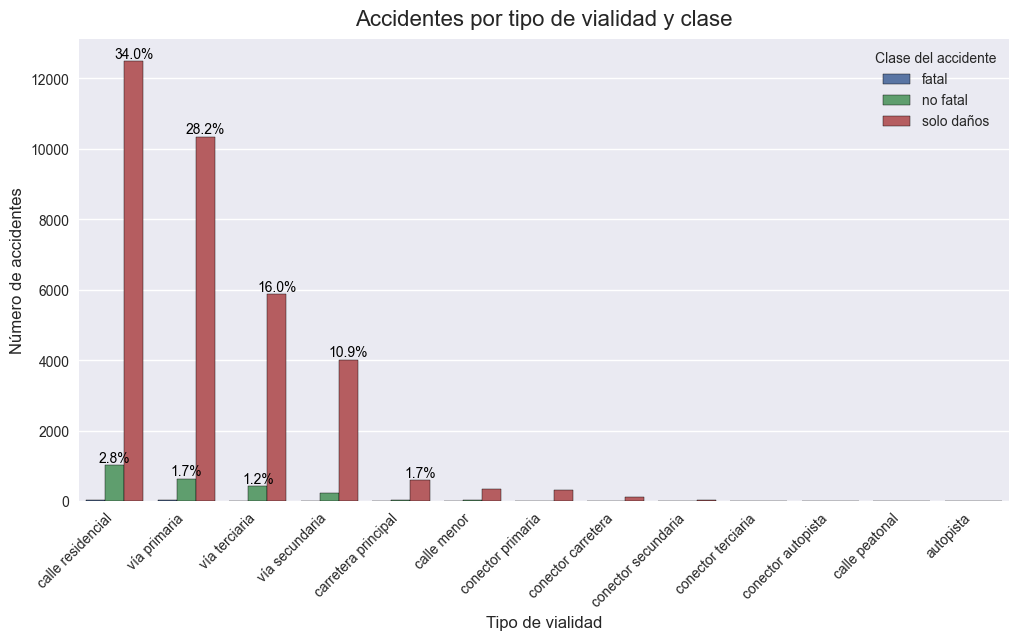

In [158]:
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=df_clase_tipov,
    x='tipo_vialidad',
    y='total_acc',
    hue='clase',
    edgecolor='black', 
    order=atus_vialidad["tipo_vialidad"].value_counts().index
)

ax.set_title('Accidentes por tipo de vialidad y clase', fontsize=16,pad=10)
ax.set_xlabel('Tipo de vialidad', fontsize=12)
ax.set_ylabel('Número de accidentes', fontsize=12)
plt.xticks(rotation=45, ha='right')

for p in ax.patches:
    height = p.get_height()
    pct = height / tot_acc  # porcentaje
    if pct > 0.01: 
        pct = 100*pct
        ax.annotate(
        f"{pct:.1f}%",
        (p.get_x() + p.get_width() / 2, height),
        ha="center", va="bottom",
        fontsize=10, color="black", rotation=0
    )

plt.legend(title='Clase del accidente', loc='upper right')
plt.savefig("../plots/accidentes_tipo_clase.png")
plt.show()

---
¿Hay diferencias significativas entre accidentes según la zona urbana?

La columna `urbana` posee información sobre la zona urbana: 

In [162]:
atus_vialidad['urbana'].unique()

array(['intersección', 'suburbana', 'no intersección'], dtype=object)

In [168]:
atus_vialidad['urbana'].value_counts(normalize=True)

urbana
intersección      0.98
no intersección   0.01
suburbana         0.01
Name: proportion, dtype: float64

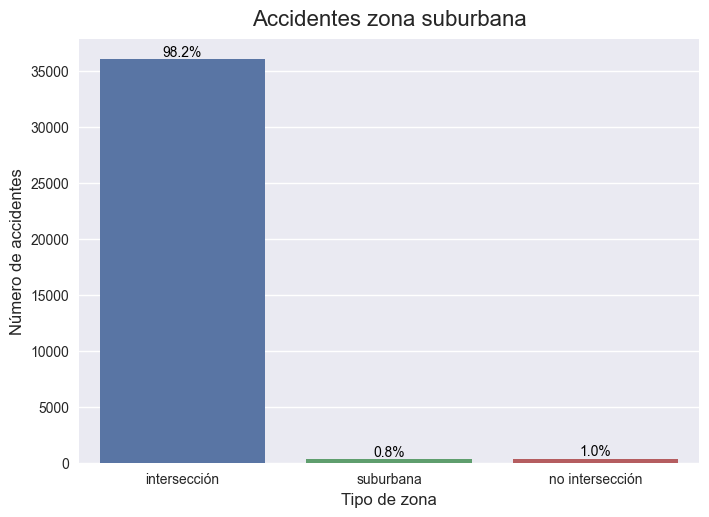

In [182]:
ax = sns.countplot(
    data=atus_vialidad, 
    x='urbana', 
    hue='urbana'
    )
for p in ax.patches:
    height = p.get_height()
    pct = 100*height / tot_acc  # porcentaje
    ax.annotate(
        f"{pct:.1f}%",
        (p.get_x() + p.get_width() / 2, height),
        ha="center", va="bottom",
        fontsize=10, color="black", rotation=0
        )
ax.set_title('Accidentes zona suburbana', fontsize=16,pad=10)
ax.set_xlabel('Tipo de zona', fontsize=12)
ax.set_ylabel('Número de accidentes', fontsize=12)
plt.savefig("../plots/accidentes_zona_surburbana.png")
plt.show()

* La diferencia entre los accidentes ocurridos por zona urbana es abrumadora: el 98% ocurre en intersecciones, el resto ocurre en no intersecciones y regiones suburbanas. 

---
¿Las vialidades coon superficies no pavimentada tienen accidentes más severos?

La columna `caparod` posee información sobre el tipo de cubrimiento de la vialidad donde ocurrio el accidente. 

In [183]:
atus_vialidad['caparod'].unique()

array(['pavimentada', 'no pavimentada'], dtype=object)

In [186]:
atus_vialidad['caparod'].value_counts()

caparod
pavimentada       36696
no pavimentada       20
Name: count, dtype: int64

* De los +36000 accidentes, solo 20 ocurrieron en vialidades sin pavimentar. 

Analicemos de cerca los accidentes en vialidades no pavimentadas: 

In [199]:
atus_no_pavimento = atus_vialidad[atus_vialidad['caparod'] == 'no pavimentada']

In [200]:
atus_no_pavimento['urbana'].value_counts()

urbana
intersección    20
Name: count, dtype: int64

* Todos los accodentes en vialidades no pavimentadas ocurrieron en intersecciones. 

In [201]:
atus_no_pavimento['clase'].value_counts()

clase
solo daños    15
no fatal       4
fatal          1
Name: count, dtype: int64

* De los 20 accidentes 1, fue fatal. 

In [207]:
atus_no_pavimento[atus_no_pavimento['clase'] =='fatal'].to_dict(); 

In [191]:
get_nonzero_vehicles(atus_no_pavimento)

0      automovil
1       campasaj
3      pascamion
6      camioneta
7         camion
8        tractor
10    motociclet
12     otrovehic
Name: vehicle, dtype: object

Los vehículos involucrados son motocicletas, tractores y otro tipo de vehículos.

### 3.3 Factor humano y condiciones

---
¿Qué causas predominan según el tipo de vialidad?

Las causas de accidentes: 

In [215]:
atus_vialidad['causaacci'].unique()

array(['conductor', 'peatón/pasajero', 'falla del vehículo'], dtype=object)

In [217]:
atus_vialidad['causaacci'].value_counts()

causaacci
conductor             36435
peatón/pasajero         277
falla del vehículo        4
Name: count, dtype: int64

El 99% de los accidentes son causados por conductores. 

## 4. Conclusiones

### Exploración espacial de accidentes y vialidades en Hermosillo (2021–2023)

#### Resumen general

* En el periodo 2021–2023 se registraron **36 716 accidentes con datos georreferenciados**.
* El conjunto de datos Vialidades-OSM contiene **154 813 segmentos**, de los cuales **88 635 (~60%) no tienen nombre asignado**.
* El total de vialidades con nombre único es **4 727**.
* De estas, **1 700 (~36%)** presentan al menos un accidente registrado.

---

#### Top 10 vialidades con más accidentes

|      | nombre_vialidad                    | tipo_vialidad     | num_accidentes | prop_accidentes | longitud_total_m | acc_por_km |
| ---: | :--------------------------------- | :---------------- | -------------: | --------------: | ---------------: | ---------: |
|  557 | boulevard solidaridad              | vía primaria      |           2996 |         8.15993 |          40652.7 |         74 |
|   10 | SIN_NOMBRE                         | calle residencial |           1365 |         3.71773 |        2 535 110 |          1 |
|  505 | boulevard josé maría morelos norte | vía primaria      |            819 |         2.23064 |          11807.3 |         70 |
|  545 | boulevard progreso                 | vía primaria      |            724 |         1.97189 |          13991.8 |         52 |
|  456 | boulevard antonio quiroga          | vía primaria      |            706 |         1.92287 |          8612.77 |         82 |
|  503 | boulevard jesús garcía morales     | vía primaria      |            669 |         1.82209 |          11812.7 |         57 |
| 1262 | luis encinas johnson               | vía primaria      |            664 |         1.80848 |          8722.45 |         77 |
| 1089 | francisco monteverde               | vía secundaria    |            404 |         1.10034 |          10550.4 |         39 |
|  644 | calle de la reforma                | vía secundaria    |            391 |         1.06493 |          6783.95 |         58 |
|   22 | abelardo l rodríguez               | vía primaria      |            384 |         1.04587 |          3212.77 |        120 |

* El *Boulevard Solidaridad* concentra **~8%** de los accidentes del periodo.
* Le siguen *Boulevard José María Morelos Norte* (~2.2%) y *Boulevard Progreso* (~2%).
* Las calles residenciales sin nombre aportan cerca del **4%** de los accidentes.
* La vialidad con mayor número de accidentes por kilómetro es **Abelardo L. Rodríguez** con **120 accidentes/km**.

---

#### Distribución por tipo de vialidad

<p align="center">
  <img src="../plots/accidentes_tipo_vialidad.png" alt="Imagen de Frecuencia de Accidentes" width="50%">
</p>

* Las **calles residenciales** y las **vías primarias** concentran más del **60%** de los accidentes.
* Les siguen las **vías terciarias**, con una proporción menor.

---

#### Distribución del número de accidentes por vialidad

<p align="center">
  <img src="../plots/distribucion_num_acc.png" alt="Imagen de Frecuencia de Accidentes" width="60%">
</p>

* El 25% de las vialidades tienen **menos de 2 accidentes**.
* El 50% tienen **menos de 4 accidentes**.
* El 75% tienen **menos de 12 accidentes**.
* El valor máximo es **2 996 accidentes**.
* De las 1 700 vialidades con accidentes, cerca de **1 600** tienen entre **1 y 10 accidentes**, mientras que solo ~100 vialidades superan los **100 accidentes**.

---

#### Longitud de la vialidad vs. número de accidentes (log–log)

<p align="center">
  <img src="../plots/corr_long_numaccid.png" alt="Imagen de Frecuencia de Accidentes" width="50%">
</p>

* La correlación entre longitud y número de accidentes es de aproximadamente **0.2**.
* Se observa una tendencia positiva: **vialidades más largas tienden a registrar más accidentes**, aunque la relación es débil.

---

#### Accidentes según número de carriles

* Aproximadamente **9 000 accidentes (~25%)** cuentan con información sobre el número de carriles.

<p align="center">
  <img src="../plots/accidentes_num_carriles.png" alt="Imagen de Frecuencia de Accidentes" width="60%">
</p>

* Al considerar solo los accidentes con este dato, el **30%** ocurre en vialidades de **4 carriles**.
* Las vialidades de **2, 3 y 5 carriles** concentran entre **18–22%** cada una.

---

#### Severidad del accidente según velocidad máxima

* Cerca de **7 000 accidentes (~20%)** poseen datos de velocidad máxima.

<p align="center">
  <img src="../plots/velmax_clase_acc.png" alt="Imagen de Frecuencia de Accidentes" width="60%">
</p>

* La mayoría ocurre en tramos señalados con **60 km/h**, que es la velocidad máxima más común en la ciudad.
* Solo **14 accidentes fatales** tienen datos de velocidad máxima; **esta muestra es insuficiente para evaluar la relación entre límite de velocidad y severidad**.

---

#### Distribución por tipo de vialidad y clase

<p align="center">
  <img src="../plots/accidentes_tipo_clase.png" alt="Imagen de Frecuencia de Accidentes" width="60%">
</p>

* La mayor parte de los accidentes se concentra en **calles residenciales**, donde también se observan más accidentes fatales.

---

#### Zona urbana vs. suburbanas

<p align="center">
  <img src="../plots/accidentes_zona_surburbana.png" alt="Imagen de Frecuencia de Accidentes" width="60%">
</p>

* El **98%** de los accidentes ocurre dentro de zonas urbanas e intersecciones.
* El resto ocurre en zonas suburbanas o fuera de intersecciones.